#### **ANN Model on Fashion MSNIT Dataset**

The Model is Trained on Fashion MNIST Dataset from Kaggle. The Model is trained on 60000 Images.It's a Multiclassification Problem as it has 10 Labels.

It has 2 Hidden Layer - 1st Layer having 128 nuerons while the 2nd Layer has 64 neurons and 10 Output Neurons. It also has 784 input layers

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [30]:
torch.manual_seed(42)  # Set random seed for reproducibility

In [31]:
# Check For GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)

Using Device: cuda


In [32]:
df = pd.read_csv("E:\\Notes\\Python'\\PyTorch\\Datasets\\Fashion-mnist\\fashion-mnist_train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


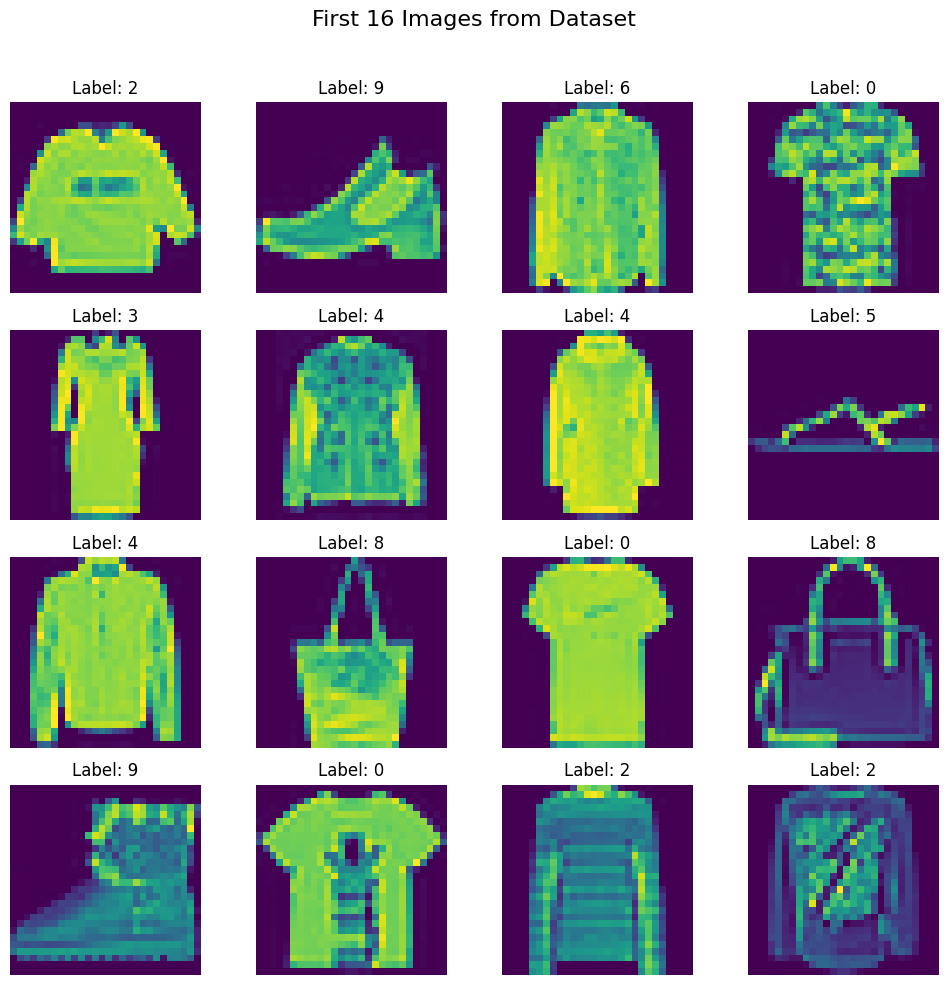

In [33]:
# Creating a Sample of the Dataset Images (4x4 Grid)
fig, axes = plt.subplots(4,4, figsize=(10, 10))
fig.suptitle("First 16 Images from Dataset", fontsize=16)

for i,ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  #Display image in grayscale
    ax.axis('off')  # Hide axes
    ax.set_title(f"Label: {df.iloc[i,0]}")  # Display label

plt.tight_layout(rect=[0,0,1,0.96]) # Adjust layout to make room for the title
plt.show()



In [34]:
# Train_Test Split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Scaling the Image Features between 0 and 1

X_train = X_train/255.0
X_test = X_test/255.0

In [36]:
X_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.        ,
        0.        ]], shape=(48000, 784))

In [37]:
# Custom Dataset

class CustomDataset(Dataset):

    def __init__(self, features, labels):

        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    
    def __len__(self):

        return len(self.features)
    
    def __getitem__(self, index):

        return self.features[index], self.labels[index]

In [38]:
# Creating a Train Dataset Object
train_dataset = CustomDataset(X_train, y_train)

In [39]:
# Creating a Test Dataset Object
test_dataset = CustomDataset(X_test, y_test)

In [40]:
# Train & Test Dataloader

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)  # pin_memory=True is used for faster data transfer to GPU
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

In [41]:
# Model Architecture

class ANN(nn.Module):

    def __init__(self, num_features):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64,10)
            # nn.Softmax(dim=1)  # Softmax is applied in the loss function
        )

    def forward(self, x):
        return self.model(x)

In [42]:
Epochs = 100
learning_rate = 0.1

In [43]:
# Object of the ANN Class
model = ANN(X_train.shape[1])
model = model.to(device) # Move the model to the same device as the data

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss combines softmax and negative log-likelihood loss

optimizer = optim.SGD(model.parameters(), lr = learning_rate, weight_decay=1e-4)

In [44]:
len(train_loader), len(test_loader)  # No. of Batches for train and test loaders

(375, 94)

In [45]:
# Training Loop

for epoch in range(Epochs):

    model.train()  # Set the Model to Training Mode
    running_loss = 0.0     # Iterate over the training data

    for batch_features, batch_labels in train_loader:

        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device) # Move to GPU if available

        # Forward Pass
        output = model(batch_features)

        # Loss
        loss = criterion(output, batch_labels)

        # Backward Pass
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()

        # Update Gradients
        optimizer.step()

        running_loss += loss.item()  # Accumulate the loss
    
    # Print the average loss for the epoch
    avg_loss = running_loss/len(train_loader)
    print(f'Epoch: {epoch+1}, Loss: {avg_loss:.4f}')


Epoch: 1, Loss: 0.6623
Epoch: 2, Loss: 0.4865
Epoch: 3, Loss: 0.4449
Epoch: 4, Loss: 0.4167
Epoch: 5, Loss: 0.3953
Epoch: 6, Loss: 0.3881
Epoch: 7, Loss: 0.3726
Epoch: 8, Loss: 0.3623
Epoch: 9, Loss: 0.3535
Epoch: 10, Loss: 0.3469
Epoch: 11, Loss: 0.3383
Epoch: 12, Loss: 0.3336
Epoch: 13, Loss: 0.3241
Epoch: 14, Loss: 0.3174
Epoch: 15, Loss: 0.3132
Epoch: 16, Loss: 0.3116
Epoch: 17, Loss: 0.3039
Epoch: 18, Loss: 0.3000
Epoch: 19, Loss: 0.2961
Epoch: 20, Loss: 0.2888
Epoch: 21, Loss: 0.2852
Epoch: 22, Loss: 0.2852
Epoch: 23, Loss: 0.2815
Epoch: 24, Loss: 0.2765
Epoch: 25, Loss: 0.2731
Epoch: 26, Loss: 0.2723
Epoch: 27, Loss: 0.2670
Epoch: 28, Loss: 0.2663
Epoch: 29, Loss: 0.2627
Epoch: 30, Loss: 0.2596
Epoch: 31, Loss: 0.2574
Epoch: 32, Loss: 0.2552
Epoch: 33, Loss: 0.2520
Epoch: 34, Loss: 0.2501
Epoch: 35, Loss: 0.2474
Epoch: 36, Loss: 0.2484
Epoch: 37, Loss: 0.2444
Epoch: 38, Loss: 0.2434
Epoch: 39, Loss: 0.2404
Epoch: 40, Loss: 0.2385
Epoch: 41, Loss: 0.2358
Epoch: 42, Loss: 0.2349
E

In [46]:
# Evaluation
model.eval()  # Because we are evaluating the model so there are differnt Prameters like dropout, batchnorm, etc.

ANN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [47]:
# Eval Code
total , correct = 0, 0

with torch.no_grad():  # No need to compute gradients during evaluation

    for batch_features, batch_labels in test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs = model(batch_features)

        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability

        total += batch_labels.shape[0]  # Total number of samples
        correct += (predicted == batch_labels).sum().item()

accuracy = correct / total
print(f'Accuracy of the model on the test set: {accuracy:.4f}')

Accuracy of the model on the test set: 0.8857


In [ ]:
# Eval Code
total , correct = 0, 0

with torch.no_grad():  # No need to compute gradients during evaluation

    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs = model(batch_features)

        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability

        total += batch_labels.shape[0]  # Total number of samples
        correct += (predicted == batch_labels).sum().item()

accuracy = correct / total
print(f'Accuracy of the model on the train set: {accuracy:.4f}')

Accuracy of the model on the train set: 0.9616


: 

Although test accuracy = 88.7%, the training accuracy = 98%.

This means the model is:

Performing well on training data but not generalizing well to unseen test data

This is called overfitting — when a model memorizes training data instead of learning patterns.